In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
except:
    print 'NOT IPYTHON'

import sys
import numpy as np
import scipy.io as sio

sys.path.append('../SPGL1_python_port')
import ca_source_extraction as cse
#%
from matplotlib import pyplot as plt
from time import time
import pylab as pl
from scipy.sparse import coo_matrix
import scipy
from sklearn.decomposition import NMF
import tempfile
import os
import tifffile
import subprocess
import time as tm
from time import time
#% for caching
import tempfile
import shutil
import os


picos not installed
cvxopt not installed


In [2]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

bpl.output_notebook()

BokehJS successfully loaded.

In [3]:
n_processes=16 # roughly number of cores on your machine minus 2

p=2 # order of the AR model (in general 1 or two)


In [4]:
print "Restarting server..."
sys.stdout.flush()  

proc_1=subprocess.Popen(["ipcluster stop"],shell=True)
tm.sleep(5)

sys.stdout.flush()    
proc_2=subprocess.Popen(["ipcluster start -n " + str(n_processes)],shell=True) 

Restarting server...


In [5]:
# LOAD MOVIE AND MAKE DIMENSIONS COMPATIBLE WITH CNMF
reload=0
filename='movies/demoMovie.tif'
t = tifffile.TiffFile(filename) 
Y = t.asarray().astype(dtype=np.float32) 
Y = np.transpose(Y,(1,2,0))
d1,d2,T=Y.shape
Yr=np.reshape(Y,(d1*d2,T),order='F')
np.save('Y',Y)
np.save('Yr',Yr)
Y=np.load('Y.npy',mmap_mode='r')
Yr=np.load('Yr.npy',mmap_mode='r')        
d1,d2,T=Y.shape
Cn = cse.local_correlations(Y)
n_pixels_per_process=d1*d2/n_processes # how to subdivide the work among processes

In [8]:
#%% prepare parameters
preprocess_params={ 'sn':None, 'g': None, 'noise_range' : [0.25,0.5], 'noise_method':'logmexp',
                    'n_processes':n_processes, 'n_pixels_per_process':n_pixels_per_process,   
                    'compute_g':False, 'p':p,   
                    'lags':5, 'include_noise':False, 'pixels':None}
init_params = { 
                    'K':30,'gSig':[4,4],'gSiz':[9,9], 
                    'ssub':1,'tsub':1,
                    'nIter':5, 'kernel':None,
                    'maxIter':5
                    }
spatial_params = {               
                    'd1':d1,  'd2':d2, 'dist':3,   'method' : 'ellipse',               
                    'n_processes':n_processes,'n_pixels_per_process':n_pixels_per_process,'backend':'ipyparallel',
                    'memory_efficient':False
                }
temporal_params = {
                    'ITER':2, 'method':'spgl1', 'p':p,
                    'n_processes':n_processes,'backend':'ipyparallel',
                    'memory_efficient':False,                                
                    'bas_nonneg':True,  
                    'noise_range':[.25,.5], 'noise_method':'logmexp', 
                    'lags':5, 'fudge_factor':1., 
                    'verbosity':False
                }

In [9]:
t1 = time()
Yr,sn,g=cse.preprocess_data(Yr,**preprocess_params)
Ain, Cin, b_in, f_in, center=cse.initialize_components(Y, **init_params)                                                    
print time() - t1  
clear_output(wait=True)
print('DONE!')

DONE!


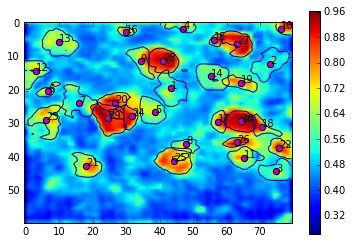

In [10]:
plt2 = plt.imshow(Cn,interpolation='None')
plt.colorbar()
plt.scatter(x=center[:,1], y=center[:,0], c='m', s=40)
crd = cse.plot_contours(coo_matrix(Ain[:,::-1]),Cn,thr=0.9)
plt.axis((-0.5,d2-0.5,-0.5,d1-0.5))
plt.gca().invert_yaxis()
pl.show()

In [11]:
p=cse.nb_plot_contour(Cn,Ain,d1,d2,thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p)

In [12]:
#%%
t1 = time()
A,b,Cin = cse.update_spatial_components_parallel(Yr, Cin, f_in, Ain, sn=sn, **spatial_params)
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

 find search location
Updated Spatial Components
threshold
Computing A_bas
--- 2.79148793221 seconds ---
Remove temporary file created
2.79557180405
DONE!


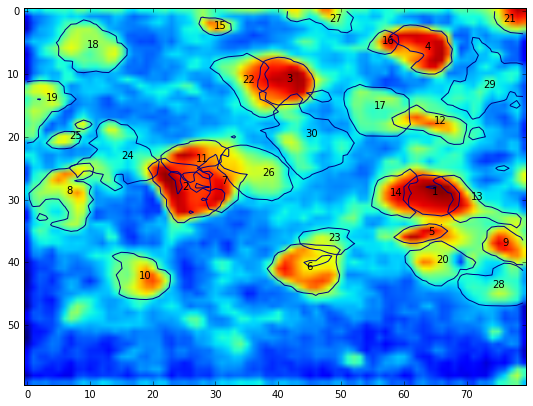

In [13]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = cse.plot_contours(A,Cn,thr=0.9)

In [14]:
p=cse.nb_plot_contour(Cn,A.todense(),d1,d2,thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p)

In [15]:
#%% update_temporal_components
t1 = time()
C,f,S,bl,c1,neurons_sn,g = cse.update_temporal_components_parallel(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**temporal_params)
t_elTEMPORAL2 = time() - t1
clear_output(wait=True)
print('DONE!')
print t_elTEMPORAL2 # took 98 sec  

DONE!
33.1298701763


In [17]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cse.mergeROIS_parallel(Yr,A,b,C,f,S,sn,temporal_params, spatial_params, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=0.8, mx=50, fast_merge = True)
t_elMERGE = time() - t1
clear_output(wait=True)
print('DONE!')
print t_elMERGE  

DONE!
10.4877741337


In [19]:
#%% refine spatial and temporal 
t1 = time()
A2,b2,C2 = cse.update_spatial_components_parallel(Yr, C_m, f, A_m, sn=sn, **spatial_params)
#C2,f2,Y_res2,S2,bl2,c12,neurons_sn2,g21 = cse.update_temporal_components_parallel(Yr,A2,b2,C2,f,bl=bl_m,c1=c1_m,sn=sn_m,g=g_m,**temporal_params)
C2,f2,S2,bl2,c12,neurons_sn2,g21 = cse.update_temporal_components_parallel(Yr,A2,b2,C2,f,bl=None,c1=None,sn=None,g=None,**temporal_params)
print time() - t1 # 100 seconds
print('DONE!')
print t_elMERGE 

 find search location
Updated Spatial Components
threshold
Computing A_bas
--- 1.19313597679 seconds ---
Remove temporary file created
1 out of total 25 temporal components updated 

3 out of total 25 temporal components updated 

6 out of total 25 temporal components updated 

8 out of total 25 temporal components updated 

14 out of total 25 temporal components updated 

18 out of total 25 temporal components updated 

25 out of total 25 temporal components updated 

2 out of total 25 temporal components updated 

3 out of total 25 temporal components updated 

5 out of total 25 temporal components updated 

7 out of total 25 temporal components updated 

12 out of total 25 temporal components updated 

18 out of total 25 temporal components updated 

25 out of total 25 temporal components updated 

stopping: overall temporal component not changing significantly
33.4707119465
DONE!
10.4877741337


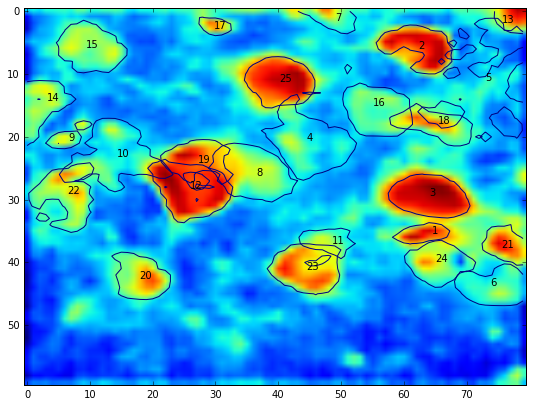

In [20]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = cse.order_components(A2,C2)
crd = cse.plot_contours(coo_matrix(A_or[:,::-1]),Cn,thr=0.9)

In [21]:
p=cse.nb_plot_contour(Cn,A_or,d1,d2,thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p)

In [ ]:
traces_fluo=cse.nb_view_patches(Yr,A_or,C_or,b2,f2,d1,d2,thr = 0.9)

In [20]:
print "Stopping Cluster...."
sys.stdout.flush()  
proc_2=subprocess.Popen(["ipcluster stop"],shell=True)


Stopping Cluster....
